In [2]:

import dataretrieval.nwis as nwis
import geopandas as gpd
from shapely.geometry import Point, box, Polygon, MultiPolygon
import requests
import pandas as pd
import datetime as dt
import earthaccess
from tqdm import tqdm
from shapely.ops import nearest_points
import sys
sys.path.append('modules/')
from retrieval_utils_appeearsTest import get_param_sites, get_scenes_results, get_scenes_temp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np
import geopy
import ast
from sklearn.preprocessing import StandardScaler

In [3]:
# set up search and call function
param_codes = ['32315'] # chla fluorescence
param_codes_str = ','.join(param_codes) 
#state_codes = ['06'] # california
state_codes = [f"{i:02d}" for i in range(1, 57)]
site_types = ['LK', 'ES'] # lakes, estruaries
site_list = get_param_sites(param_codes_str, state_codes, site_types)

# drop missing coords
site_list['dec_lat_va'] = pd.to_numeric(site_list['dec_lat_va'], errors='coerce')
site_list['dec_long_va'] = pd.to_numeric(site_list['dec_long_va'], errors='coerce')
site_list_clean = site_list.dropna(subset=['dec_lat_va', 'dec_long_va'])

# drop bottom measurements
site_list_surf = site_list_clean[~site_list_clean['station_nm'].str.contains('bottom|deep', case=False, na=False)]
site_list_surf['site_no'] = site_list_surf['site_no'].astype(str)

# convert headers to appeears format, save to csv
sites_df = pd.DataFrame()
sites_df['ID'] = site_list_surf['site_no'] 
sites_df['Category'] = site_list_surf['station_nm']
sites_df['Latitude'] = site_list_surf['dec_lat_va']
sites_df['Longitude'] = site_list_surf['dec_long_va']
sites_df['ID'] = sites_df['ID'].astype(str)
sites_df.to_csv(f"data/{param_codes[0]}_sites.csv", index=False)


Finding sites: 100%|████████████████████████████| 56/56 [01:38<00:00,  1.77s/it]

90


In [4]:
# import data
param_codes = ['32316']
spec_df = pd.read_csv(f"data/{param_codes[0]}_spectra.csv") 
site_list = pd.read_csv(f"data/{param_codes[0]}_sites.csv", dtype={'ID': str})
site_list.rename(columns={'ID': 'site_no', 'Category': 'station_nm'}, inplace=True)

# trim station names for matching
def trim_station_nm(name):
    name = name.replace('(', '').replace(')', '')
    return name.split(',')[0].strip().lower()
site_list['station_nm_trimmed'] = site_list['station_nm'].apply(trim_station_nm)

# collapse spectral data into list of dicts
grouped = spec_df.groupby(['Category', 'Date'])
scenes = []
for (category, date), group in grouped:
    spectral_data = group[['Band', 'wavelength', 'reflectance']].to_dict('records')
    scene = {
        'datetime': pd.to_datetime(date).strftime('%Y-%m-%dT%H:%M:%S.000Z'),
        'station_nm': category,
        'lat': group['Latitude'].iloc[0],
        'lon': group['Longitude'].iloc[0],
        'spectra': spectral_data
    }
    scenes.append(scene)
scenes_df = pd.DataFrame(scenes)

# merge datasets to get site no column
scenes_df['station_nm_trimmed'] = scenes_df['station_nm'].apply(trim_station_nm)
merged_df = scenes_df.merge(site_list[['station_nm_trimmed', 'site_no']], on='station_nm_trimmed', how='left')
merged_df.drop(columns=['station_nm_trimmed'], inplace=True)

# check for any NaN values in site_no
if merged_df['site_no'].isna().any():
    missing_station_nms = merged_df[merged_df['site_no'].isna()]['station_nm'].unique()
    print("\nMissing site_no for station names:", missing_station_nms)

print(merged_df.head())


                   datetime                       station_nm        lat  \
0  2023-08-12T22:32:34.000Z  BLUE RIVER LAKE NEAR BLUE RIVER  44.173194   
1  2024-03-26T23:22:56.000Z  BLUE RIVER LAKE NEAR BLUE RIVER  44.173194   
2  2024-03-30T21:47:23.000Z  BLUE RIVER LAKE NEAR BLUE RIVER  44.173194   
3  2024-04-21T18:32:59.000Z  BLUE RIVER LAKE NEAR BLUE RIVER  44.173194   
4  2024-08-01T20:41:02.000Z  BLUE RIVER LAKE NEAR BLUE RIVER  44.173194   

          lon                                            spectra  \
0 -122.324222  [{'Band': 'B001', 'wavelength': 381.006, 'refl...   
1 -122.324222  [{'Band': 'B001', 'wavelength': 381.006, 'refl...   
2 -122.324222  [{'Band': 'B001', 'wavelength': 381.006, 'refl...   
3 -122.324222  [{'Band': 'B001', 'wavelength': 381.006, 'refl...   
4 -122.324222  [{'Band': 'B001', 'wavelength': 381.006, 'refl...   

           site_no  
0  441022122193200  
1  441022122193200  
2  441022122193200  
3  441022122193200  
4  441022122193200  


In [5]:
# import mask and ensure format matches
mask_df = pd.read_csv(f"data/{param_codes[0]}_mask.csv")
mask_df.rename(columns={
    'Date': 'datetime',
    'Category': 'station_nm'
}, inplace=True)
mask_df['datetime'] = pd.to_datetime(mask_df['datetime'])
mask_df['datetime'] = mask_df['datetime'].dt.strftime('%Y-%m-%dT%H:%M:%S.000Z')
mask_df.drop(columns=['ID', 'Latitude', 'Longitude', 'elev'], inplace=True)

# merge condensed spectral data with masks
merged_mask_df = pd.merge(merged_df, mask_df, on=['station_nm', 'datetime'], how='left')

# filter for water and cloud
water_scenes = merged_mask_df[merged_mask_df['water_flag'] == 1]
visible_scenes = water_scenes[(water_scenes['cloud_flag'] == 0) & (water_scenes['cirrus_flag'] == 0)]
visible_scenes.reset_index(drop=True, inplace=True)
print(visible_scenes.head())

                   datetime                       station_nm        lat  \
0  2023-08-12T22:32:34.000Z  BLUE RIVER LAKE NEAR BLUE RIVER  44.173194   
1  2024-03-26T23:22:56.000Z  BLUE RIVER LAKE NEAR BLUE RIVER  44.173194   
2  2024-03-30T21:47:23.000Z  BLUE RIVER LAKE NEAR BLUE RIVER  44.173194   
3  2024-04-21T18:32:59.000Z  BLUE RIVER LAKE NEAR BLUE RIVER  44.173194   
4  2024-08-01T20:41:02.000Z  BLUE RIVER LAKE NEAR BLUE RIVER  44.173194   

          lon                                            spectra  \
0 -122.324222  [{'Band': 'B001', 'wavelength': 381.006, 'refl...   
1 -122.324222  [{'Band': 'B001', 'wavelength': 381.006, 'refl...   
2 -122.324222  [{'Band': 'B001', 'wavelength': 381.006, 'refl...   
3 -122.324222  [{'Band': 'B001', 'wavelength': 381.006, 'refl...   
4 -122.324222  [{'Band': 'B001', 'wavelength': 381.006, 'refl...   

           site_no  cirrus_flag  cloud_flag  water_flag  
0  441022122193200          0.0         0.0         1.0  
1  441022122193200      

In [4]:
# import results, ensure spectra is list of dicts
param_codes = ['32315']
results = pd.read_csv(f"data/{param_codes[0]}_results.csv", dtype={'site_no': str})
results['spectra'] = results['spectra'].apply(ast.literal_eval)

# query the USGS database for temperature results, merge tables
temps = get_scenes_temp(results)
results['datetime'] = pd.to_datetime(results['datetime'], utc=True)
temps['datetime'] = pd.to_datetime(temps['datetime'], utc=True)
comb_results = pd.merge(results, temps, on=['site_no', 'datetime'], how='left')


Finding temperature for scenes: 100%|███████████| 62/62 [01:52<00:00,  1.82s/it]


In [5]:
results = comb_results

# define band ranges
blue_range = (450, 495)
green_range = (495, 570)
red_range = (620, 750)
nir_range = (750, 900)

# filter the spectra for relevant bands
def filter_bands(spectra, blue_range, green_range, red_range, nir_range):
    filtered_spectra = []
    for scene in spectra:
        wavelength = scene['wavelength']
        reflectance = scene['reflectance']

        # exclude invalid reflectance values
        if reflectance == -9999.0:
            continue
        if blue_range[0] <= wavelength <= blue_range[1]:
            filtered_spectra.append(scene)
        elif green_range[0] <= wavelength <= green_range[1]:
            filtered_spectra.append(scene)
        elif red_range[0] <= wavelength <= red_range[1]:
            filtered_spectra.append(scene)
        elif nir_range[0] <= wavelength <= nir_range[1]:
            filtered_spectra.append(scene)

    return filtered_spectra

# apply the filter
results['spectra'] = results['spectra'].apply(
    lambda x: filter_bands(x, blue_range, green_range, red_range, nir_range)  
)

# remove scenes with NaN reflectance values in target bands
results = results[results['spectra'].apply(lambda x: len(x) > 0)]
results.reset_index(drop=True, inplace=True)
print(results['spectra'].head())

0    [{'Band': 'B011', 'wavelength': 455.17, 'refle...
1    [{'Band': 'B011', 'wavelength': 455.17, 'refle...
2    [{'Band': 'B011', 'wavelength': 455.17, 'refle...
3    [{'Band': 'B011', 'wavelength': 455.17, 'refle...
4    [{'Band': 'B011', 'wavelength': 455.17, 'refle...
Name: spectra, dtype: object


/var/folders/z1/jv48g1md32b8z_bqznh_bzb40000gn/T/ipykernel_38227/2090549304.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  results['month_year'] = results['datetime'].dt.to_period('M')  # Create month_year from datetime
/var/folders/z1/jv48g1md32b8z_bqznh_bzb40000gn/T/ipykernel_38227/2090549304.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = results.groupby(['month_year', 'chla_range']).size().unstack(fill_value=0)


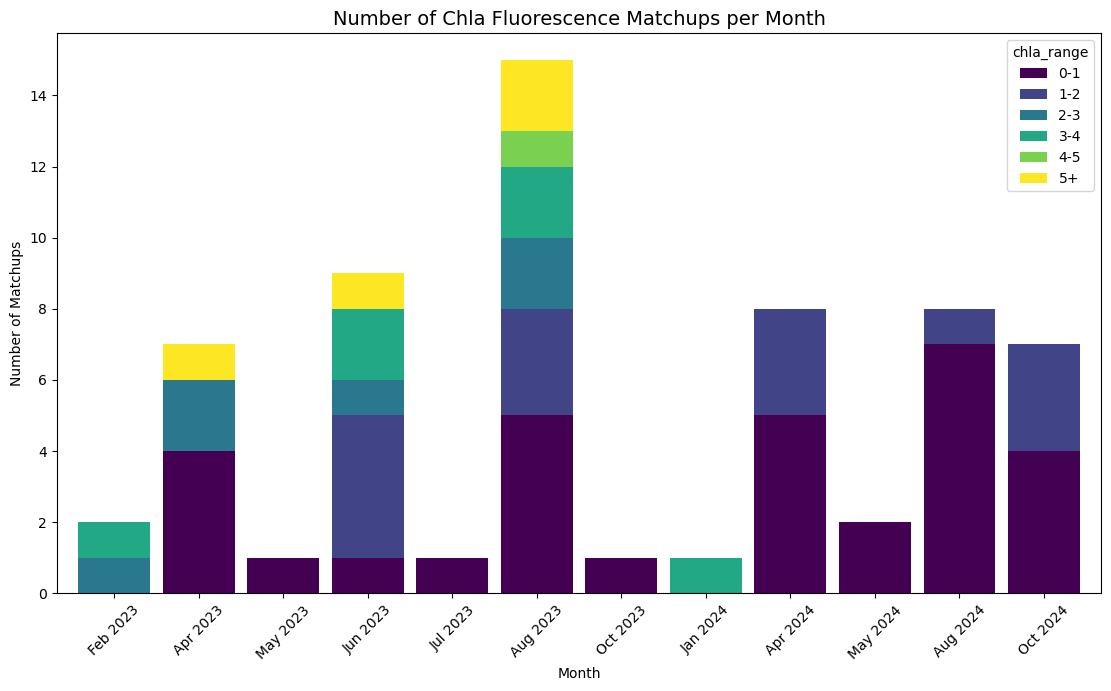

In [7]:
results = pd.read_csv(f"data/{param_codes[0]}_results.csv", dtype={'site_no': str})
results['spectra'] = results['spectra'].apply(ast.literal_eval)

results['datetime'] = pd.to_datetime(results['datetime'], utc=True)
results['month_year'] = results['datetime'].dt.to_period('M')  # Create month_year from datetime
# Create 'chla_range' column based on 'result' (chlorophyll-a concentration)
bins = [0, 1, 2, 3, 4, 5, np.inf]  # Define ranges with a focus on lower values
labels = ['0-1', '1-2', '2-3', '3-4', '4-5', '5+']  # Labels for the ranges
results['chla_range'] = pd.cut(results['result'], bins=bins, labels=labels, right=False)


# Group by month_year and Chla range for stacked bar chart
grouped = results.groupby(['month_year', 'chla_range']).size().unstack(fill_value=0)

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))
grouped.plot(kind='bar', stacked=True, ax=ax, cmap='viridis', width=0.85)  # Adjust width to make bars closer

# Set title and labels
ax.set_title('Number of Chla Fluorescence Matchups per Month', fontsize=14)
ax.set_xlabel('Month')
ax.set_ylabel('Number of Matchups')

# Customize x-axis labels
ax.set_xticklabels([date.strftime('%b %Y') for date in grouped.index.to_timestamp()], rotation=45)

# Adjust layout to minimize space
plt.tight_layout()  # Ensures no overlap of labels
plt.subplots_adjust(left=0.08, right=0.95, top=0.9, bottom=0.2)  # Fine-tune padding around the plot

plt.show()


In [9]:
# display unique sites and their scene counts
num_unique_sites = comb_results['site_no'].nunique()
scenes_per_site = comb_results['site_no'].value_counts().reset_index()
scenes_per_site.columns = ['site_no', 'scene_count']

print(scenes_per_site.head())
print(f"Number of unique sites: {num_unique_sites}")


           site_no  scene_count
0  400853105563701            8
1        011008745            6
2  410613073215801            5
3  410606073245700            5
4  410729073171701            5
Number of unique sites: 22


In [12]:

# select a site to plot
site_no_plot = '295826095082200' 
site_scenes = results[results['site_no'] == site_no_plot]

# explode the spectra
spectra_list = []
for index, row in site_scenes.iterrows():
    for spectrum in row['spectra']:
        spectra_list.append({
            'datetime': row['datetime'],
            'site_no': row['site_no'],
            'station_nm': row['station_nm'],
            'result': row['result'],
            'wavelength': spectrum['wavelength'],
            'reflectance': spectrum['reflectance']
        })
spectra_df = pd.DataFrame(spectra_list)

# remove invalid spectra and limit sides to 1000
spectra_df['reflectance'] = spectra_df['reflectance'].replace(-9999, np.nan)
spectra_df['reflectance'] = spectra_df['reflectance'].where(abs(spectra_df['reflectance'] - (-0.01)) > 1e-8, np.nan)
spectra_df['reflectance'] = spectra_df['reflectance'].where(spectra_df['reflectance'] >= 0, np.nan)
spectra_df = spectra_df[(spectra_df['wavelength'] >= 400) & (spectra_df['wavelength'] <= 900)]

# set colour map
norm = mcolors.Normalize(vmin=site_scenes['result'].min(), vmax=site_scenes['result'].max())
cmap = cm.Greens
cmap = cmap(np.linspace(0.1, 1, cmap.N))
cmap = mcolors.ListedColormap(cmap)

# plot the spectra
plt.figure(figsize=(12, 6))
for datetime, group in spectra_df.groupby('datetime'):
    result_label = group['result'].iloc[0]
    color = cmap(norm(result_label))
    plt.plot(group['wavelength'], group['reflectance'], color=color, label=datetime.strftime('%Y-%m-%d %H:%M:%S'))

plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title(f"Spectra vs In Situ for Site: {site_scenes['station_nm'].iloc[0]}")
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=plt.gca(), label='Chla (ug/l)', orientation='vertical')
plt.grid(True)
plt.tight_layout()
plt.show()



KeyError: 'reflectance'